In [1]:
import torch 
import gpytorch
import sys 
import os
sys.path.append(os.path.abspath('../..'))
from data import SystemLoader, PVWeatherGenerator
from models import MultitaskGPModel, HadamardGPModel
from kernels import get_mean_covar, get_mean_covar_weather
from likelihoods.beta import MultitaskBetaLikelihood, HadamardBetaLikelihood
from matplotlib import pyplot as plt


In [3]:
DAY_INIT = 0 # start of data is 01-01-2018
N_DAYS = 365 # data until 01-01-2019
DAY_MIN = 8 # starting hour of all our data (per day)
DAY_MAX = 16 # ending hour of all our data (per day)
MINUTE_INTERVAL = 5 # the minute interval of our data
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_DAYS_FOLD = 7 
N_SYSTEMS = 6
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [4]:
generator = PVWeatherGenerator(
        coords=CIRCLE_COORDS,
        radius=RADIUS,
        day_init=DAY_INIT,
        n_systems=N_SYSTEMS,
        n_days=N_DAYS,
        minute_interval=MINUTE_INTERVAL,
    )
df = generator.df
num_tasks = N_SYSTEMS
num_latents = N_SYSTEMS // 2 + 1 # = 4
interval = 6


==> Loading data
==> Loaded data in: 0 m : 13 sec



In [36]:
train_interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD)
loader = SystemLoader(df, train_interval=train_interval, n_hours_pred=6)

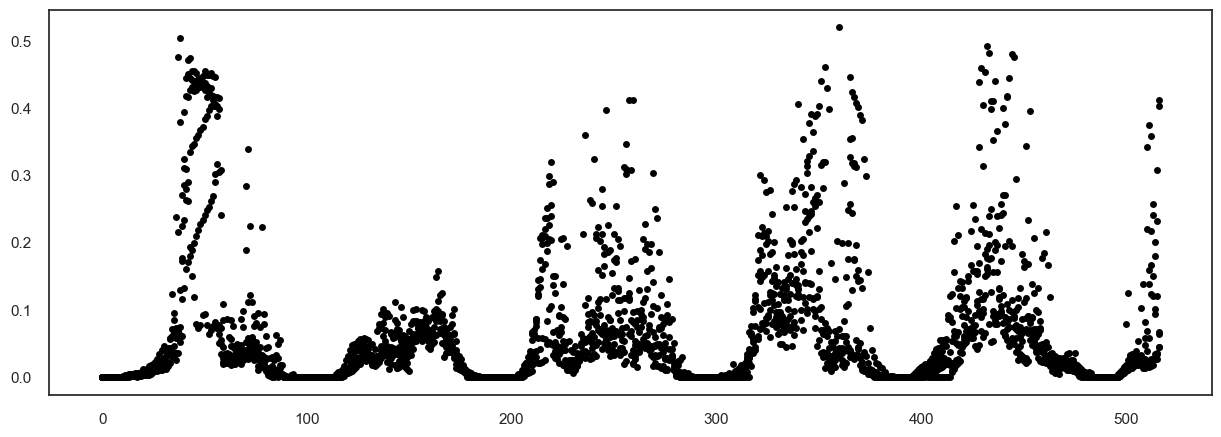

In [37]:
for i, (X_tr, Y_tr, X_te, Y_te, T_tr, T_te) in enumerate(loader):
    
    y_train = torch.stack([Y_tr[T_tr == t] for t in range(num_tasks)], dim=-1).float()
    y_test = torch.stack([Y_te[T_te == t] for t in range(num_tasks)], dim=-1).float()
    x =  torch.linspace(0, 100, len(y_train) + len(y_test), dtype=torch.float32)
    x_train, x_test = x[:len(y_train)], x[len(y_train):]

    plt.rcParams.update({'font.family': 'Arial'})
    # set figure size
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(y_train, 'o', color='black', markersize=5)
    
    zero_mean, quasi_periodic = get_mean_covar(num_latent=num_latents, base_kernel='matern')
    _, weather_qp = get_mean_covar_weather(num_latents=num_latents, d=X_tr.shape[1])
    constant_mean = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
    kroenecker_likelihood = MultitaskBetaLikelihood(scale=15, num_tasks=y_train.size(-1))
    hadamard_likelihood = HadamardBetaLikelihood(scale=15, num_tasks=y_train.size(-1))
    
    # model = MultitaskGPModel(
    #     X=x_train,
    #     y=y_train,
    #     likelihood=kroenecker_likelihood,
    #     mean_module=zero_mean,
    #     covar_module=quasi_periodic,
    #     num_latents=num_latents,
    #     jitter=1e-3,
    #     learn_inducing_locations=True,
    # )
    
    hadamard =  HadamardGPModel(
                    X=X_tr[::interval],
                    y=Y_tr[::interval],
                    mean_module=zero_mean,
                    covar_module=weather_qp,
                    likelihood=HadamardBetaLikelihood(num_tasks=num_tasks, scale=15),
                    num_tasks=num_tasks,
                    num_latents=num_latents,
                    learn_inducing_locations=False,
                    inducing_proportion=1,
                    jitter=1e-6,
                )
    break

In [38]:
# model.fit(n_iter=250, lr=0.2, verbose=True)
hadamard.fit(n_iter=250, lr=0.2, verbose=True, task_indices=T_tr[::interval])

Iter 10/250 - Loss: 3.133126957704249
Iter 20/250 - Loss: -0.26812889528271855
Iter 30/250 - Loss: -2.0257993135060186
Iter 40/250 - Loss: -2.725925651332516
Iter 50/250 - Loss: -3.09882430500748
Iter 60/250 - Loss: -3.290567686942343
Iter 70/250 - Loss: -3.387368588764564
Iter 80/250 - Loss: -3.4366914060770393
Iter 90/250 - Loss: -3.462785605012546
Iter 100/250 - Loss: -3.4820366170595443
Iter 110/250 - Loss: -3.470280384944383
Iter 120/250 - Loss: -3.4934669848046975
Iter 130/250 - Loss: -3.505087247906745
Iter 140/250 - Loss: -3.5120865583259993
Iter 150/250 - Loss: -3.5059310961923624
Iter 160/250 - Loss: -3.516740902538986
Iter 170/250 - Loss: -3.5202623148452776
Iter 180/250 - Loss: -3.50147371084755
Iter 190/250 - Loss: -3.52377169982869
Iter 200/250 - Loss: -3.5251719056024124


KeyboardInterrupt: 

In [39]:
# median_tr, lower_tr, upper_tr = model.predict(x_train, pred_type='median')
# median_te, lower_te, upper_te = model.predict(x_test, pred_type='median')

median_tr_h, lower_tr_h, upper_tr_h = hadamard.predict(X_tr, task_indices=T_tr)
median_te_h, lower_te_h, upper_te_h = hadamard.predict(X_te, task_indices=T_te)

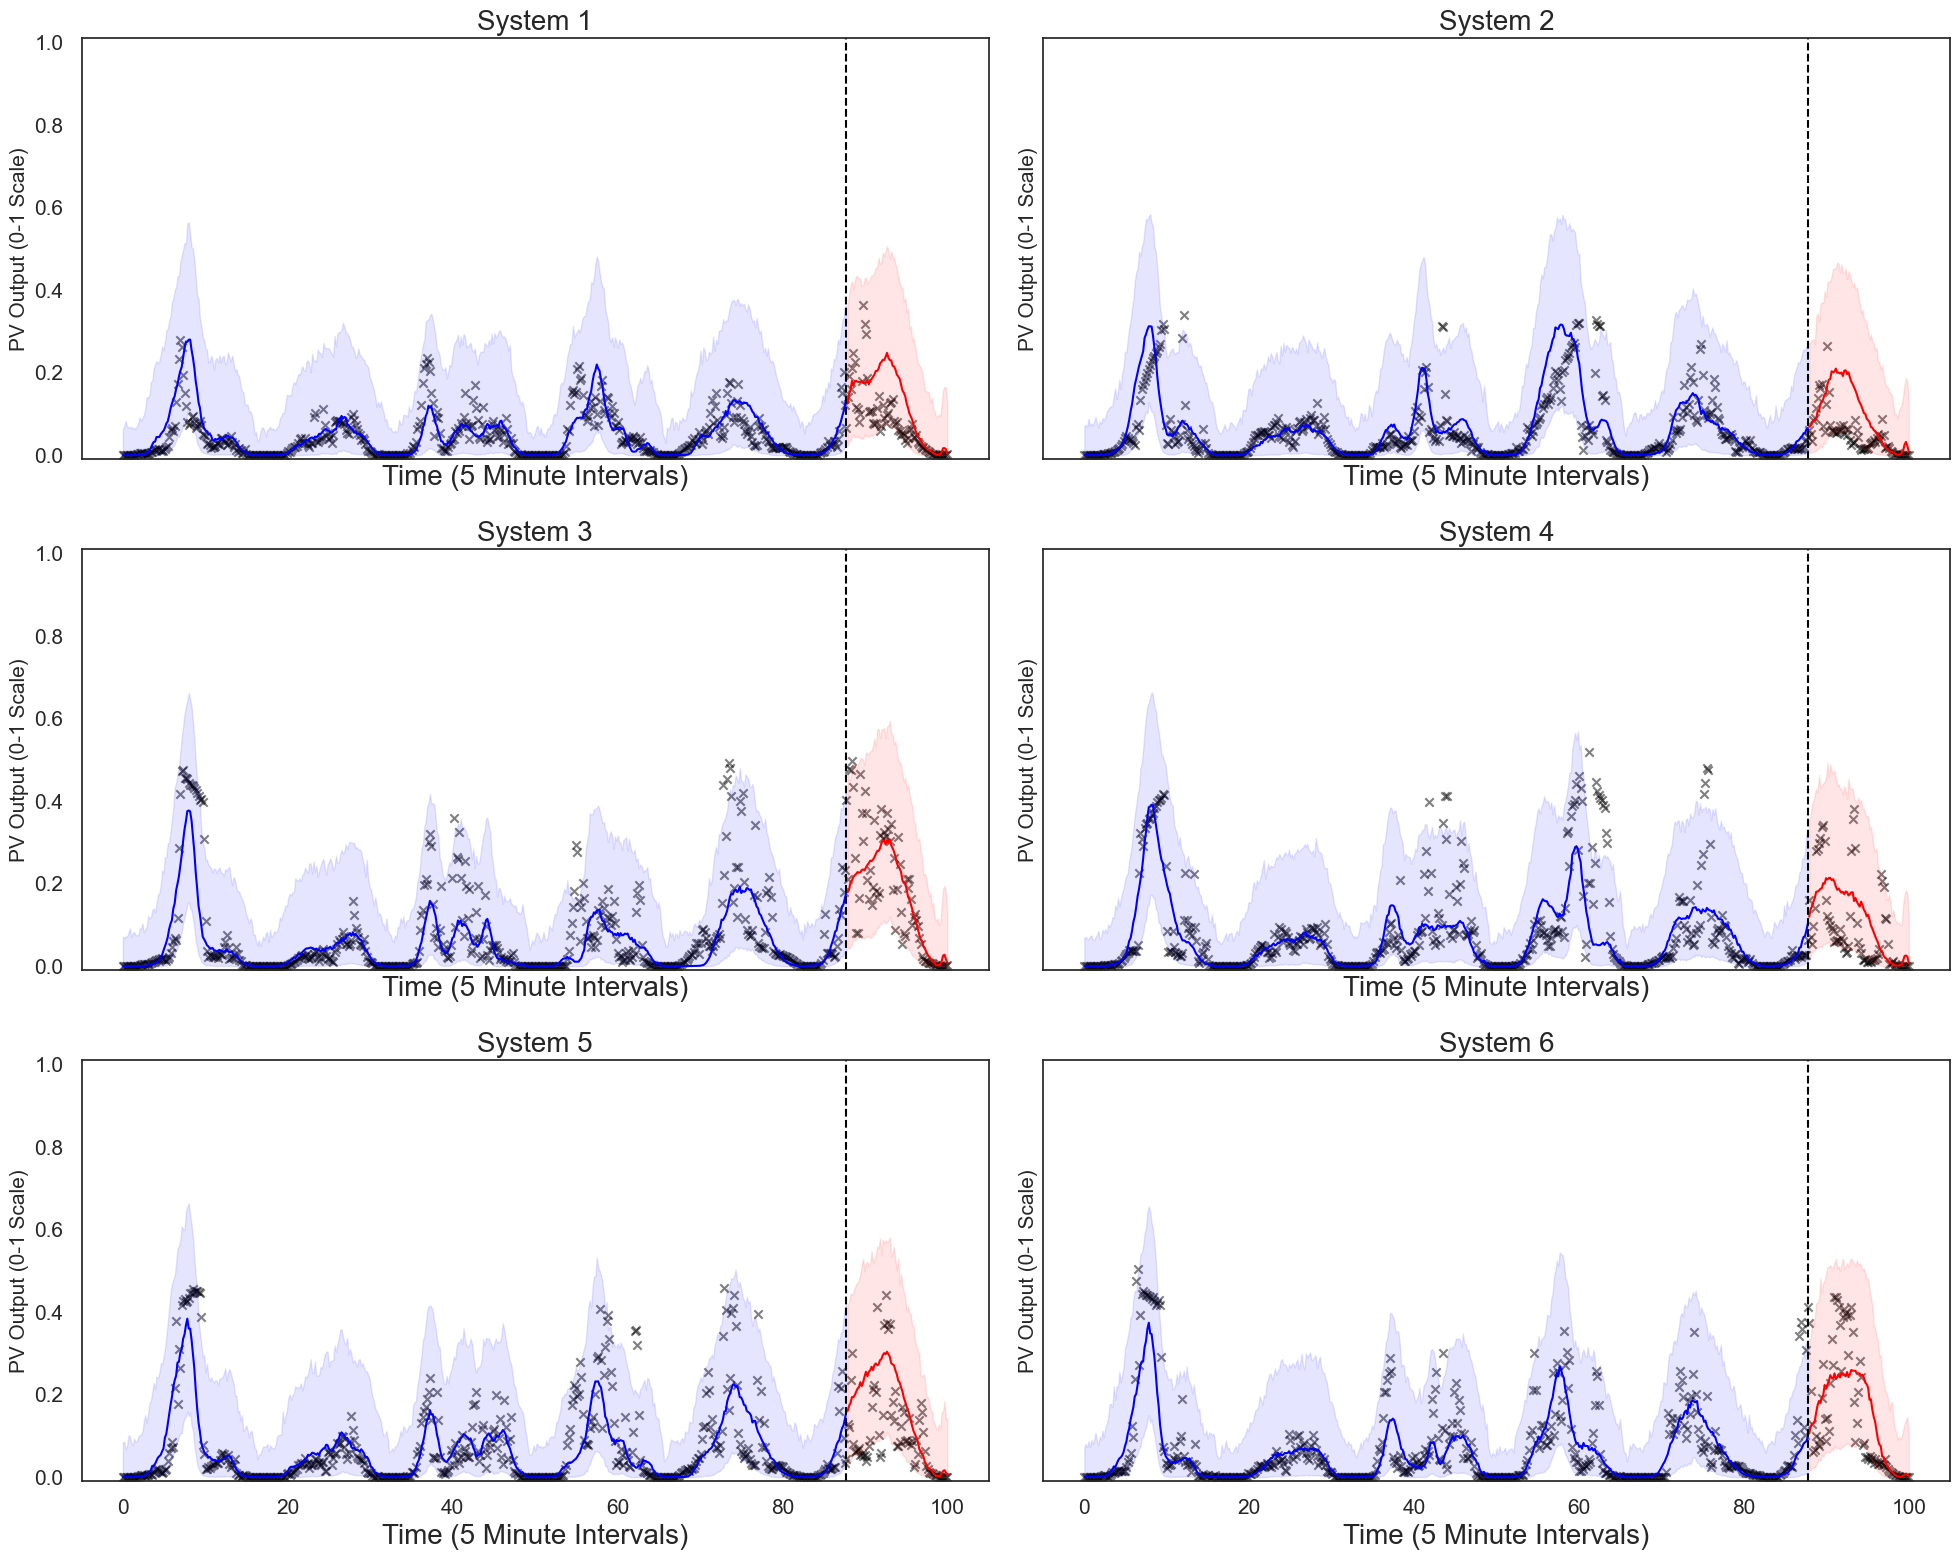

In [44]:
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots(num_tasks // 2, 2, figsize=(20, 16), sharey=True, sharex=True)
ax = ax.flatten()

for task in range(num_tasks):
    mask = T_tr == task
    m_tr, l_tr, u_tr = median_tr_h[mask], lower_tr_h[mask], upper_tr_h[mask]
    mask = T_te == task
    m_te, l_te, u_te = median_te_h[mask], lower_te_h[mask], upper_te_h[mask]

    ax[task].scatter(x_train, y_train[:,task], label='Observed Data', marker='x', color='black', alpha=0.5)
    ax[task].scatter(x_test, y_test[:,task], marker='x', color='black', alpha=0.5)
    ax[task].plot(x_train, m_tr, color='blue')
    ax[task].fill_between(x_train, l_tr, u_tr, alpha=0.1, color='blue')
    ax[task].plot(x_test, m_te, color='red')
    ax[task].fill_between(x_test, l_te, u_te, alpha=0.1, color='red')
    ax[task].axvline(x_train.max(), color='black', linestyle='--', label='Train/Test Split')
    ax[task].set_title(f'System {task+1}',fontsize=20)
    ax[task].set_ylabel('PV Output (0-1 Scale)',fontsize=15)
    # set fontsize of y tick labels
    ax[task].tick_params(axis='both', which='major', labelsize=15)

    # set xlabel
    ax[task].set_xlabel('Time (5 Minute Intervals)',fontsize=20)

    # ax[task][1].scatter(x_train, y_train[:,task], label='Observed Data', marker='x', color='black', alpha=0.5)
    # ax[task][1].scatter(x_test, y_test[:,task], marker='x', color='black', alpha=0.5)
    # ax[task][1].plot(x_train, m_tr, color='blue')
    # ax[task][1].fill_between(x_train, l_tr, u_tr, alpha=0.1, color='blue')
    # ax[task][1].plot(x_test, m_te, color='red')
    # ax[task][1].fill_between(x_test, l_te, u_te, alpha=0.1, color='red')
    # ax[task][1].axvline(x_train.max(), color='black', linestyle='--', label='Train/Test Split')

    ax[task].set_ylabel('PV Output (0-1 Scale)',fontsize=15)
    # set fontsize of y tick labels
    ax[task].tick_params(axis='both', which='major', labelsize=15)

# ax[0][0].set_title(f'Kroenecker GP',fontsize=20)
# ax[0][1].set_title(f'Hadamard GP',fontsize=20)
# ax[num_tasks-1][0].set_xlabel('Time (5 Minute Intervals)',fontsize=20)
# ax[num_tasks-1][1].set_xlabel('Time (5 Minute Intervals)',fontsize=20)

# ax[num_tasks-1][0].set_xticklabels([0] + np.arange(0, len(x_train) + len(x_test), 120).tolist(), fontsize=15)
# ax[num_tasks-1][1].set_xticklabels([0] + np.arange(0, len(x_train) + len(x_test), 120).tolist(), fontsize=15)
plt.ylim(-0.01, 1.01)

plt.tight_layout()
plt.savefig('had_6hr.png', dpi=300)
plt.show();


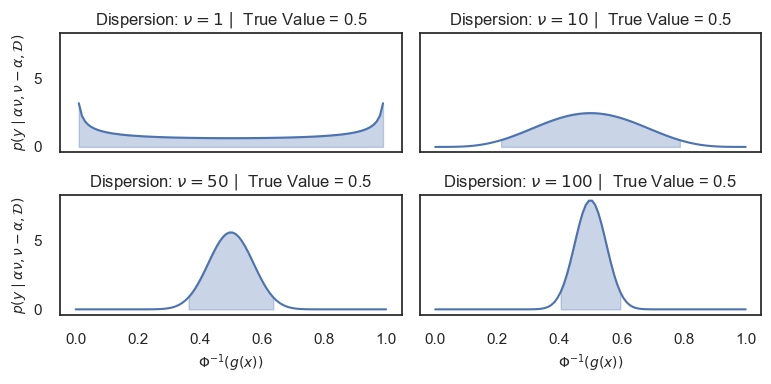

<Figure size 800x550 with 0 Axes>

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

x = torch.linspace(0, 1, 100)
dispersion = [1, 10, 50, 100]

# Confidence level (e.g., 95%)
confidence_level = 0.95

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(8, 4), sharex=True, sharey=True)
ax = ax.flatten()

for i, v in enumerate(dispersion):
    alpha = torch.tensor(v) * 0.5
    beta = torch.tensor(v) - alpha
    alpha = torch.clamp(alpha, min=1e-3)
    beta = torch.clamp(beta, min=1e-3)
    dist = torch.distributions.beta.Beta(alpha, beta)
    pred_likelihood = dist.log_prob(x).exp()

    ax[i].plot(x, pred_likelihood)
    ax[i].set_title(r"Dispersion: $\nu={} \mid$".format(v) + ' True Value = 0.5')

    # Calculate the 95% confidence interval
    lower_bound = stats.beta.ppf((1 - confidence_level) / 2, alpha, beta)
    upper_bound = stats.beta.ppf(1 - (1 - confidence_level) / 2, alpha, beta)

    ax[i].fill_between(x, 0, pred_likelihood, where=(x >= lower_bound) & (x <= upper_bound), color='b', alpha=0.3)

    # set ylabels only for the left column
    if i % 2 == 0:
        ax[i].set_ylabel(r"$p(y \mid \alpha \nu, \nu - \alpha, \mathcal{D})$", fontsize=10)

    # set xlabels only for the bottom row
    if i >= 2:
        ax[i].set_xlabel(r"$\Phi^{-1}(g(x))$", fontsize=10)


plt.tight_layout()
plt.show()
plt.savefig('dispersion.png', dpi=800)
